# Predicting Daily Market Movements with QDA
This experiment uses Quadratic Discriminant Analysis (QDA) to predict daily returns. The experiment starts by analyzing predictors and their relations with daily market movements. Data is then extracted and cleaned and the predictors are extracted from the data. Metrics are computed to determine the viability of the model, providing insghts into the model's fitting and performance. The model is then tested on in-sample and out-of-sample to determine the model's performance. To conclude the experiment, the strategy is simulated to see how the model would have performed historically.

In [21]:
# File imports
import numpy as np
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.multivariate import test_cov_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.stats import normaltest

# Import ISLP-Specific Functions/Classes
from ISLP import confusion_table
from ISLP.models import(
    ModelSpec as MS,
    summarize
)

# Import settings
plt.style.use('ggplot')

### 1. Assessing Predictors and Responses
The predictors used for the QDA model are specified below.

In [22]:
t_data = yf.download('SPY', start='1980-01-01', interval='1d', auto_adjust=True)

# Re-format the yahoo finance data
data = pd.DataFrame()
data['Close'] = t_data['Close']
data['Volume'] = t_data['Volume']

# Calculate the daily returns
data['Returns'] = data['Close'].pct_change()

# Daily return lags
data['Ret_Lag1'] = data['Returns'].shift(1)
data['Ret_Lag2'] = data['Returns'].shift(2)
data['Ret_Lag3'] = data['Returns'].shift(3)
data['Ret_Lag4'] = data['Returns'].shift(4)
data['Ret_Lag5'] = data['Returns'].shift(5)

# Daily volume lags
data['Vol_Lag1'] = data['Volume'].shift(1)
data['Vol_Lag2'] = data['Volume'].shift(2)
data['Vol_Lag3'] = data['Volume'].shift(3)
data['Vol_Lag4'] = data['Volume'].shift(4)
data['Vol_Lag5'] = data['Volume'].shift(5)

# Calculate the rolling volatility
data['volatility_1'] = data['Returns'].rolling(window=2).std()
data['volatility_2'] = data['Returns'].rolling(window=3).std()
data['volatility_3'] = data['Returns'].rolling(window=4).std()
data['volatility_4'] = data['Returns'].rolling(window=5).std()
data['volatility_5'] = data['Returns'].rolling(window=6).std()


# Clean the data
data.dropna(axis=0, inplace=True)
del data['Close']

# Label the return data to their respective classes (K=2)
data['Direction'] = np.where(data['Returns'] > 0, 'Up', 'Down')

[*********************100%***********************]  1 of 1 completed


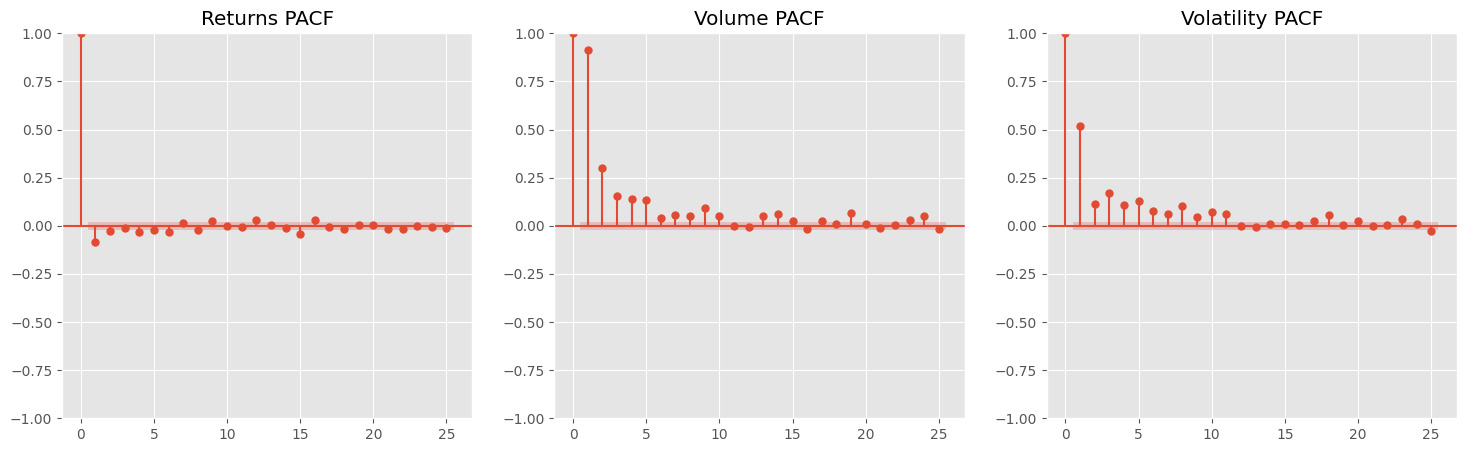

In [23]:
# Plot the partial autocorrelation of the lagged returns, lagged volume, and rolling volatility
N_LAGS = 25

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

plot_pacf(data['Returns'], ax=axes[0], title='Returns PACF', lags=N_LAGS)
plot_pacf(data['Volume'], ax=axes[1],  title='Volume PACF', lags=N_LAGS)
plot_pacf(data['volatility_1'], ax=axes[2],  title='Volatility PACF', lags=N_LAGS)
plt.show()

In [24]:
# Calculate the correlations between the predictors and the daily returns
for col in data.columns:
    if col not in ['Returns', 'Close', 'Volume', 'Direction']:
        correlation = np.corrcoef(data['Returns'], data[col])[0][1]

        print(f'Correlation (Returns, {col}) = {correlation}')

Correlation (Returns, Ret_Lag1) = -0.08287196397141937
Correlation (Returns, Ret_Lag2) = -0.019313209912227562
Correlation (Returns, Ret_Lag3) = -0.008784010947519167
Correlation (Returns, Ret_Lag4) = -0.027937977513309026
Correlation (Returns, Ret_Lag5) = -0.018615954559592966
Correlation (Returns, Vol_Lag1) = 0.0037362524688291485
Correlation (Returns, Vol_Lag2) = 0.003948700065628433
Correlation (Returns, Vol_Lag3) = -0.0017256820132925568
Correlation (Returns, Vol_Lag4) = 0.0017553606757099167
Correlation (Returns, Vol_Lag5) = -0.0013059578492654186
Correlation (Returns, volatility_1) = 0.048310073132224074
Correlation (Returns, volatility_2) = 0.02959160473480817
Correlation (Returns, volatility_3) = 0.029057669963262034
Correlation (Returns, volatility_4) = 0.022480019551234312
Correlation (Returns, volatility_5) = 0.018667935001443217


The PACF plots for the three general versions of the predictors suggest that there is autocorrelation in the predictors (particularly strong autocorrelation in Volume and Volatility). Futhermore, the correlations between the identified predictors and the daily returns are weak, suggesting there is an insignificant linear relationship between the response and the predictor, justifying the use of the QDA model rather than a linear classifier.

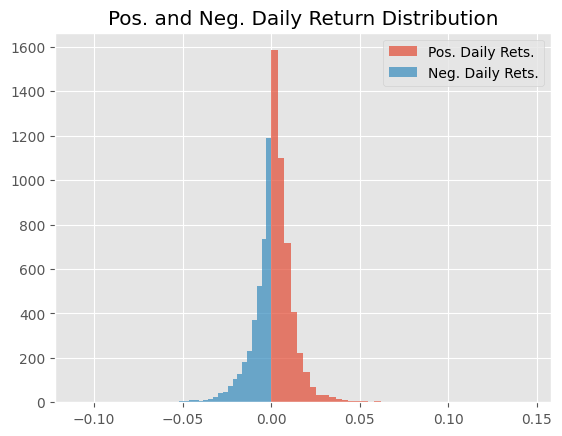

Number of Positive Daily Returns: 4379 | 53.988410800147946%
Number of Negative Daily Returns: 3732 | 46.011589199852054%


In [25]:
# Extract the positive and negative daily returns
positive_rets = data['Returns'][data['Returns'] > 0]
negative_rets = data['Returns'][data['Returns'] <= 0]

# Plot the distributions of the positive and negative daily returns
plt.hist(positive_rets, bins=40, alpha=0.7, label='Pos. Daily Rets.')
plt.hist(negative_rets, bins=40, alpha=0.7, label='Neg. Daily Rets.')
plt.title('Pos. and Neg. Daily Return Distribution')
plt.legend()
plt.show()

print(f'Number of Positive Daily Returns: {len(positive_rets)} | {(len(positive_rets) / len(data)) * 100}%')
print(f'Number of Negative Daily Returns: {len(negative_rets)} | {(len(negative_rets) / len(data)) * 100}%')

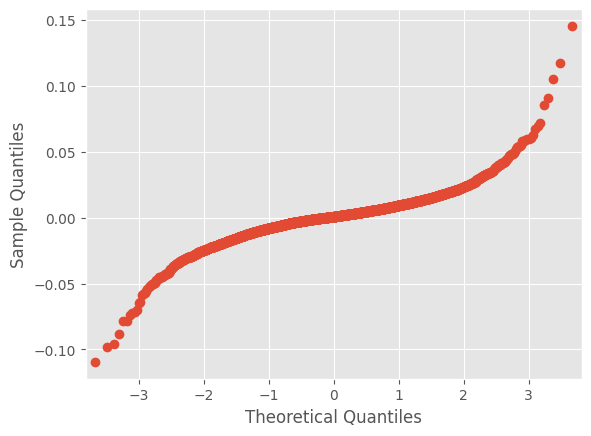

In [26]:
# Q-Q Plot of daily returns
sm.qqplot(data['Returns'])
plt.show()

#### Discussion and Findings
Observing the Q-Q Plot, the pronounced S-curve of the plot indicates that the distribution of daily returns is either skewed or has different tails compared to the normal distribution. As seen in the distribution of daily returns, the distribution is left-skewed, with more positive daily returns. Rougly 54% of the daily returns are positive and 46% of the daily returns are negative. By inspection, the daily return distribution appears to have fat tails with some daily returns around +/-5%. Because QDA assumes predictors are drawn from a normal distribution, the code below tests the predictors for normality.<br>
Null Hypothesis: Data is a normal distribution<br>
Alternative Hypothesis: Data is not a normal distribution

In [27]:
# Test the predictors for normality
alpha = 0.05

# Seperate the predictor columns
predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

for predictor in predictor_columns:
    stat, pvalue = normaltest(data[predictor])

    if pvalue <= alpha:
        print(f'95% confident that: {predictor} is normally distributed.')
    else:
        print(f'95% confident that: {predictor} is not normally distributed.')

95% confident that: Ret_Lag1 is normally distributed.
95% confident that: Ret_Lag2 is normally distributed.
95% confident that: Ret_Lag3 is normally distributed.
95% confident that: Ret_Lag4 is normally distributed.
95% confident that: Ret_Lag5 is normally distributed.
95% confident that: Vol_Lag1 is normally distributed.
95% confident that: Vol_Lag2 is normally distributed.
95% confident that: Vol_Lag3 is normally distributed.
95% confident that: Vol_Lag4 is normally distributed.
95% confident that: Vol_Lag5 is normally distributed.
95% confident that: volatility_1 is normally distributed.
95% confident that: volatility_2 is normally distributed.
95% confident that: volatility_3 is normally distributed.
95% confident that: volatility_4 is normally distributed.
95% confident that: volatility_5 is normally distributed.


We can see that all of the predictors appear to be a normal distribution at the 95% confidence interval.

In [28]:
# Seperate the predictors and the response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

In [29]:
# Check collinearity using the variance inflation factor (VIF)
vifs = [VIF(X, i) for i in range(1, X.shape[1])]
vifs = pd.DataFrame({'VIF' : vifs}, index=X.columns[1:])

print(vifs)

                    VIF
Ret_Lag1       1.081829
Ret_Lag2       1.146656
Ret_Lag3       1.149790
Ret_Lag4       1.134906
Ret_Lag5       1.049728
Vol_Lag1       7.847246
Vol_Lag2       9.802595
Vol_Lag3      10.129396
Vol_Lag4       9.959264
Vol_Lag5       7.963311
volatility_1   3.166281
volatility_2   8.368349
volatility_3  15.968475
volatility_4  25.042071
volatility_5  16.342613


We can see from the VIF values that there are collinear predictors, particularly lagged volume and rolling volatility. To remove the collinearity, each predictor (lagged volume and rolling volatility) will be combined into their own single predictors by taking the mean value of their lagged/rolling period.

In [30]:
# Combine the collinear predictors
data['Lag_Volume'] = data[['Vol_Lag1', 'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5']].mean(axis=1)
data['Lag_Volatility'] = data[['volatility_1', 'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5']].mean(axis=1)

# Remove the lagged columns
data.drop(columns=[
    'Vol_Lag1', 'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5',
    'volatility_1', 'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5'
], inplace=True)

predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

# NOTE: By removing the Lag_Volume and the Lag_Volatility and keeping the one day lagged volume and volatility, the model performs better AND VIF is lower

In [ ]:
NON_PREDICTOR_COLS = 2 # Number of non-predictor columns
p = len(data.columns) - NON_PREDICTOR_COLS
n = len(data)

print(f'Ratio of predictors to observations: {p / n}')

# Seperate the predictors and the response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

# Check collinearity again using the variance inflation factor (VIF)
vifs = [VIF(X, i) for i in range(1, X.shape[1])]
vifs = pd.DataFrame({'VIF' : vifs}, index=X.columns[1:])

print(vifs)

Ratio of predictors to observations: 0.0009863148810257674
                     VIF
Ret_Lag1        1.013006
Ret_Lag2        1.032589
Ret_Lag3        1.041575
Ret_Lag4        1.047218
Ret_Lag5        1.036392
Lag_Volume      1.243656
Lag_Volatility  1.324027


In [32]:
# Display the basic summary of the data
print(f'Predictor Data Set Shape: {X.shape}')
print(f'Class Distribution: \n{pd.Series(y).value_counts()}')

# NOTE: True is "Up" and False is "Down"

Predictor Data Set Shape: (8111, 8)
Class Distribution: 
Direction
True     4379
False    3732
Name: count, dtype: int64


In [ ]:
TRAIN = 0.80
train_len = int(len(data) * TRAIN)

X_train, X_test = X[:train_len], X.iloc[-train_len:]
y_train, y_test = y[:train_len], y.iloc[-train_len:]
D = data.Direction
L_train, L_test = D[:train_len], D.iloc[-train_len:]

# Remove the intercept (set my the MS.fit_transform)
X_train = X_train.drop(columns='intercept')
X_test = X_test.drop(columns='intercept')

In [34]:
# Quadratic discriminant analysis (test data)
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

print(X_test)

qda_predictions = qda.predict(X_test)

            intercept  Ret_Lag1  Ret_Lag2  Ret_Lag3  Ret_Lag4  Ret_Lag5  \
Date                                                                      
1999-07-14        1.0 -0.003574 -0.004449  0.005930  0.000783  0.001345   
1999-07-15        1.0  0.005605 -0.003574 -0.004449  0.005930  0.000783   
1999-07-16        1.0  0.006354  0.005605 -0.003574 -0.004449  0.005930   
1999-07-19        1.0  0.005428  0.006354  0.005605 -0.003574 -0.004449   
1999-07-20        1.0 -0.006611  0.005428  0.006354  0.005605 -0.003574   
...               ...       ...       ...       ...       ...       ...   
2025-04-22        1.0 -0.023803  0.001427 -0.022228 -0.002801  0.009701   
2025-04-23        1.0  0.026018 -0.023803  0.001427 -0.022228 -0.002801   
2025-04-24        1.0  0.015495  0.026018 -0.023803  0.001427 -0.022228   
2025-04-25        1.0  0.021049  0.015495  0.026018 -0.023803  0.001427   
2025-04-28        1.0  0.007225  0.021049  0.015495  0.026018 -0.023803   

            Lag_Volume  

In [35]:
# Performance metrics
confusion_matrix = confusion_table(qda_predictions, L_test)
print(confusion_matrix)

prediction_rate = np.mean(qda_predictions == L_test)
training_error = np.mean(qda_predictions != L_test)

print('\nQDA: Test Model Performance ==========')
print(f'Prediction Rate: {prediction_rate}')
print(f'Training Error:  {training_error}')

Truth      Down    Up
Predicted            
Down       2965  3523
Up            0     0

QDA: Test Model Performance ==========
Prediction Rate: 0.45699753390875464
Training Error:  0.5430024660912454


### 2. Cross-Validation
To better assess the model's test error rate, LOOCV (leave-one-out cross-validation) will be used. Fitting n-1 QDA models, where n is the number of observations in the data set, we can getter a better estimate of the model's performance compared to the simple validation set approach used above.

In [60]:
import warnings
warnings.filterwarnings('ignore')

errors = []

for i in range(len(data)):
    idx = data.index[i]
    training_data = data.drop(index=idx)
    test_data = pd.DataFrame(data.iloc[i]).T

    # Create the training data
    L_train = training_data.Direction
    X_train = MS(predictor_columns).fit_transform(training_data)

    # Create the test data
    actual_direction = test_data['Direction'].iloc[0]
    test_data = MS(predictor_columns).fit_transform(test_data)

    # Remove the intercept columns
    X_train = X_train.drop(columns='intercept')
    test_data = test_data.drop(columns='intercept')

    # Fit the QDA model to the training data
    qda = QDA(store_covariance=True)
    qda.fit(X_train, L_train)

    prediction = qda.predict(test_data)

    if prediction[0] != actual_direction:
        errors.append(1)
    else:
        errors.append(0)

estimated_error = np.mean(errors)
print(f'Estimated LOOCV Test Error: {estimated_error}')

Estimated LOOCV Test Error: 0.42485513500184935
